# Interactive Demo with Emission Lines

This notebook outlines the motivation, theory, implementation, and application of Prospector to fit spectro-photometry including the impact of emission lines.

## Preamble

First let's set up some environmental dependencies. These just make the numerics easier and adjust some of the plotting defaults to make things more legible.

In [1]:
import time, sys, os
import h5py
from scipy import stats

%pylab
%matplotlib inline

# re-defining plotting defaults
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'xtick.color': 'k'})
rcParams.update({'ytick.color': 'k'})
rcParams.update({'font.size': 30})

fout = sys.stdout
fnull = open(os.devnull, 'w')

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


**Prospector** utilizes three main packages:
- **fsps**, which governs the fundamental stellar population synthesis models (via the **python-fsps** package),
- **sedpy**, which utilizes some routines for computing spectrophotometry, and
- **prospect**, which is where most of the actual heavy lifting is done.

Let's import those now.

In [2]:
import fsps
import sedpy
import prospect

/home/joshspeagle/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


## SED model

We now want to initialize our SED model.

In [3]:
from prospect.models import model_setup

Let's now load in our model parameter file.

In [4]:
clargs = {'param_file':'demo_mock_params.py'}
run_params = model_setup.get_run_params(argv='demo_mock_params.py', **clargs)
print run_params

{'tau': 3.0, 'verbose': True, 'niter': 512, 'normalize_spectrum': False, 'whi': 7200.0, 'initial_disp': 0.1, 'outfile': 'output/demo_mock', 'nburn': [32, 32, 64], 'maxfev': 5000, 'do_powell': True, 'nwalkers': 128, 'mass': 10000000.0, 'param_file': 'demo_mock_params.py', 'ftol': 5e-06, 'logzsol': -0.5, 'dust2': 0.3, 'tage': 12.0, 'zcontinuous': 1, 'wlo': 3750.0, 'debug': False, 'snr': 20.0, 'add_noise': False, 'logify_spectrum': False}


Our model is composed of four components:
- an **stellar population synthesis (SPS)** model for the underlying physical parameters,
- a **noise model** for the underlying calibration vector,
- an underlying **statistical model** composed of a set of parameters, priors, etc., and
- a set of **observations** we are trying to fit.

See the *demo_mock_params.py* file for additional info on the specific parameters we are initializing here.

In [5]:
# load sps model (default)
sps = model_setup.load_sps(**run_params)

In [6]:
# load noise model (none)
spec_noise, phot_noise = model_setup.load_gp(**run_params)

In [7]:
# demo model
model = model_setup.load_model(**run_params)

In [8]:
# demo data (generated from the script)
obs = model_setup.load_obs(**run_params)

reading py script demo_mock_params.py


In [9]:
# initialize data
obs['unc'] = obs['true_spectrum'] / 4. # S/N = 4
obs['mask'] = ones_like(obs['unc'], dtype='bool')
obs['spectrum'] = normal(obs['true_spectrum'], obs['unc']) # jitter
obs['maggies'] = normal(obs['true_maggies'], obs['maggies_unc']) # jitter

### Model Preview

Let's take a quick look at our model/data to get a sense of what we're dealing with and what we're fitting for.

In [10]:
Ntheta = len(model.free_params)
print 'Free params:', model.free_params
print 'Fixed params:', model.fixed_params

Free params: ['mass', 'logzsol', 'tau', 'tage', 'dust2']
Fixed params: ['zred', 'sfh', 'pmetals', 'sfstart', 'tburst', 'fburst', 'dust1', 'dust_index', 'dust1_index', 'dust_tesc', 'dust_type', 'add_dust_emission', 'duste_umin', 'tpagb_norm_type', 'add_agb_dust_model', 'agb_dust', 'add_neb_emission', 'gas_logz', 'gas_logu', 'phot_jitter']


We're fitting for 5 parameters here:
- stellar mass $M_\star$,
- metallicity $\log Z/Z_\odot$, 
- star formation timescale $\tau$ for an exponentially declining star formation history (SFH), 
- age $t$ of the galaxy, and 
- dust attenuation of old stellar populations $A_V$.

Everything else here is fixed either explicitly in the *demo_mock_params.py* file or implicitly in the FSPS defaults.

### SED Preview

Let's see what our model and data look like.

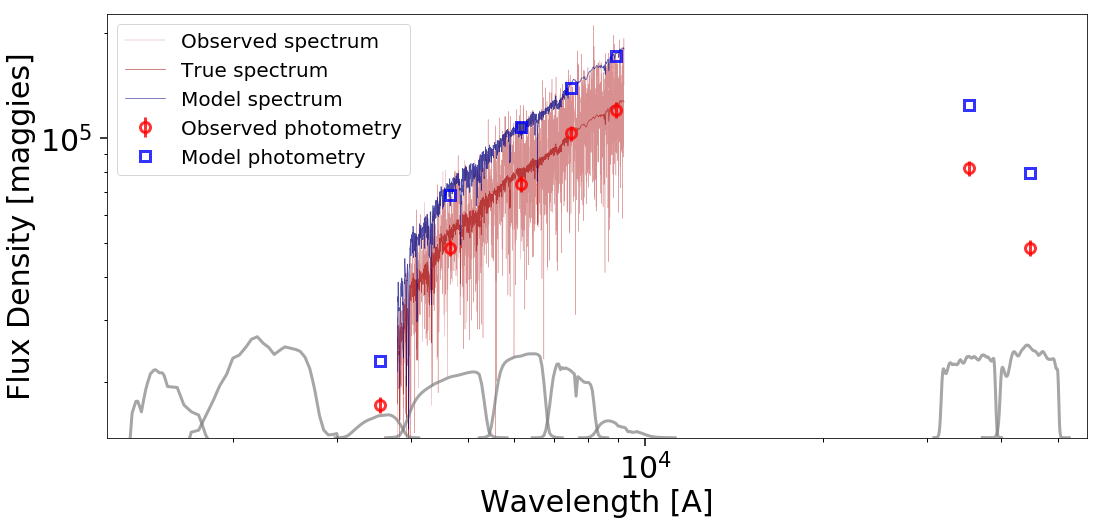

In [11]:
# spectral wavelengths
if obs['wavelength'] is not None: 
    wspec = obs['wavelength']
else:
    wspec = sps.csp.wavelengths
wphot = array([f.wave_effective for f in obs['filters']]) # photometric effective wavelengths
wphot_width = array([f.effective_width for f in obs['filters']]) # photometric effective widths

initial_theta = model.rectify_theta(model.initial_theta) # initial parameters
mspec_init, mphot_init, mextra_init = model.mean_model(initial_theta, obs, sps=sps) # generate model

# establish bounds
xmin, xmax = wphot.min()*0.8, wphot.max()/0.8
temp = interp(linspace(xmin,xmax,10000), wspec, mspec_init)
ymin, ymax = temp.min()*0.8, temp.max()/0.8

# plotting 
figure(figsize=(16,8))
for i in xrange(len(wphot)):
    f = obs['filters'][i]
    w, t = f.wavelength.copy(), f.transmission.copy()
    while t.max() > 1:
        t /= 10.
    t = 0.1*(ymax-ymin)*t + ymin
    loglog(w, t, lw=3, color='gray', alpha=0.7)
if obs['spectrum'] is not None:
    loglog(wspec, obs['spectrum'], lw=0.4, color='firebrick', alpha=0.5, label='Observed spectrum', zorder=1)
loglog(wspec, obs['true_spectrum'], lw=0.7, color='firebrick', alpha=0.8, label='True spectrum', zorder=1)
errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'], ecolor='red', marker='o', ls='', lw=3, markersize=10, 
         markerfacecolor='none', markeredgecolor='red', markeredgewidth=3, alpha=0.8, 
         label='Observed photometry', zorder=2)
loglog(wspec, mspec_init, lw=0.7, color='navy', alpha=0.7, label='Model spectrum', zorder=3)
errorbar(wphot, mphot_init, marker='s', ls='', lw=3, markersize=10,
         markerfacecolor='none', markeredgecolor='blue', markeredgewidth=3, alpha=0.8, 
         label='Model photometry', zorder=4)
xlabel('Wavelength [A]')
ylabel('Flux Density [maggies]')
xlim([xmin, xmax])
ylim([ymin, ymax])
legend(loc='best', fontsize=20)
tight_layout()

## Statistical Model

We now need to construct an associated statistical model to define our result. We take our observations to be normally distributed such that our likelihood is simply

$$ P(\mathbf{\hat{F}} \,|\, \boldsymbol{\theta}) = \mathcal{N}\left[\Delta\mathbf{\hat{F}}(\boldsymbol{\theta}) \:|\: \mathbf{0}, \mathbf{\hat{C}} \right] $$

where $\Delta\mathbf{\hat{F}}(\boldsymbol{\theta}) \equiv \mathbf{F}(\boldsymbol{\theta}) - \mathbf{\hat{F}}$. The corresponding log-likelihood is then

$$ \ln P(\mathbf{\hat{F}} \,|\, \boldsymbol{\theta}) = -\frac{1}{2}\Delta\mathbf{\hat{F}}(\boldsymbol{\theta})^T \mathbf{\hat{C}}^{-1} \Delta\mathbf{\hat{F}}(\boldsymbol{\theta}) + Z_{\mathbf{\hat{F}}} $$

where 

$$ Z_{\mathbf{\hat{F}}} = -\frac{1}{2} ( N_{\mathbf{\hat{F}}} \ln 2\pi + \ln|\mathbf{\hat{C}}| ) $$ 

is a normalization constant.

In this demo case where our covariances are independent and diagonal (i.e. our points are all sampled independently from each other), we can factor our posteriors such that

\begin{align}
\ln P(\boldsymbol{\theta} \,|\, \mathbf{\hat{F}}_{\textrm{spec}}, \mathbf{\hat{F}}_{\textrm{phot}}) 
&= \ln P(\boldsymbol{\theta} \,|\, \mathbf{\hat{F}}_{\textrm{spec}}) +  \ln P(\boldsymbol{\theta} \,|\, \mathbf{\hat{F}}_{\textrm{phot}}) \\
&= \ln P(\mathbf{\hat{F}}_{\textrm{spec}} \,|\, \boldsymbol{\theta}) +  \ln P(\mathbf{\hat{F}}_{\textrm{phot}} \,|\, \boldsymbol{\theta}) + \ln P(\boldsymbol{\theta}) \\
&= -\frac{1}{2}\Delta\mathbf{\hat{F}}_{\textrm{spec}}(\boldsymbol{\theta})^T \mathbf{\hat{C}}_{\textrm{spec}}^{-1} \Delta\mathbf{\hat{F}}_{\textrm{spec}}(\boldsymbol{\theta}) + Z_{\mathbf{\hat{F}}_{\textrm{spec}}}
-\frac{1}{2}\Delta\mathbf{\hat{F}}_{\textrm{phot}}(\boldsymbol{\theta})^T \mathbf{\hat{C}}_{\textrm{phot}}^{-1} \Delta\mathbf{\hat{F}}_{\textrm{phot}}(\boldsymbol{\theta}) + Z_{\mathbf{\hat{F}}_{\textrm{phot}}} 
+ \ln P(\boldsymbol{\theta}) \\
&\equiv -\frac{1}{2}\left[\chi^2_{\textrm{spec}} + \chi^2_{\textrm{phot}} \right] + Z_{\mathbf{\hat{F}}_{\textrm{spec}}} + Z_{\mathbf{\hat{F}}_{\textrm{phot}}} + \ln P(\boldsymbol{\theta})
\end{align}

Using individual components of this model imported from Prospector, we define our log-posterior below.

In [12]:
from prospect.likelihood import lnlike_spec, lnlike_phot, write_log

def lnprobfn(theta):
    """
    Given a parameter vector and a dictionary of observational data and a model object, 
    return the ln of the posterior. This requires that an sps object (and if using spectra 
    and gaussian processes, a GP object) be instantiated.
    """

    lnp_prior = model.prior_product(theta)
    if isfinite(lnp_prior):
        
        # Generate mean model
        t1 = time.time()
        try:
            mu, phot, x = model.mean_model(theta, obs, sps=sps)
        except(ValueError):
            return -np.infty
        d1 = time.time() - t1

        # Noise modeling
        if spec_noise is not None:
            spec_noise.update(**model.params)
        if phot_noise is not None:
            phot_noise.update(**model.params)
        vectors = {'spec': mu, 'unc': obs['unc'],
                   'sed': model._spec, 'cal': model._speccal,
                   'phot': phot, 'maggies_unc': obs['maggies_unc']}

        # Calculate log-likelihoods
        t2 = time.time()
        lnp_spec = lnlike_spec(mu, obs=obs, spec_noise=spec_noise, **vectors)
        lnp_phot = lnlike_phot(phot, obs=obs, phot_noise=phot_noise, **vectors)
        d2 = time.time() - t2
        if verbose:
            write_log(theta, lnp_prior, lnp_spec, lnp_phot, d1, d2)

        return lnp_prior + lnp_phot + lnp_spec
    
    else:
        return -np.infty

## Burning in: Optimization

We can attempt to initialize our model reasonably close to the data by using some numerical minimization routines.

In [13]:
from prospect import fitting
from scipy.optimize import minimize

In [14]:
def neglnprobfn(theta):
    """Negative of lnprobfn for minimization, and also handles passing in
    keyword arguments which can only be postional arguments when using scipy
    minimize.
    """
    return -lnprobfn(theta)

verbose=False # don't output function calls

# start minimization
min_method = 'Nelder-Mead'
ts = time.time()
min_results = minimize(neglnprobfn, initial_theta, method=min_method)
pdur = time.time() - ts

# output results
print('done {0} in {1}s'.format(min_method, pdur))
print('best {0} guess: {1}'.format(min_method, min_results.x))
print('best {0} lnp: {1}'.format(min_method, -min_results.fun))

done Nelder-Mead in 10.333427906s
best Nelder-Mead guess: [  7.44336835e+06  -3.92262862e-01   1.34337925e+00   6.56382234e+00
   2.15953726e-01]
best Nelder-Mead lnp: -22166.3355506


Note that creating a new model with FSPS is somewhat time-intensive, but once the relevant model(s) have been loaded they are subsequently stored in cache so similar models can be generated much more quickly.

Now let's see how our model looks.

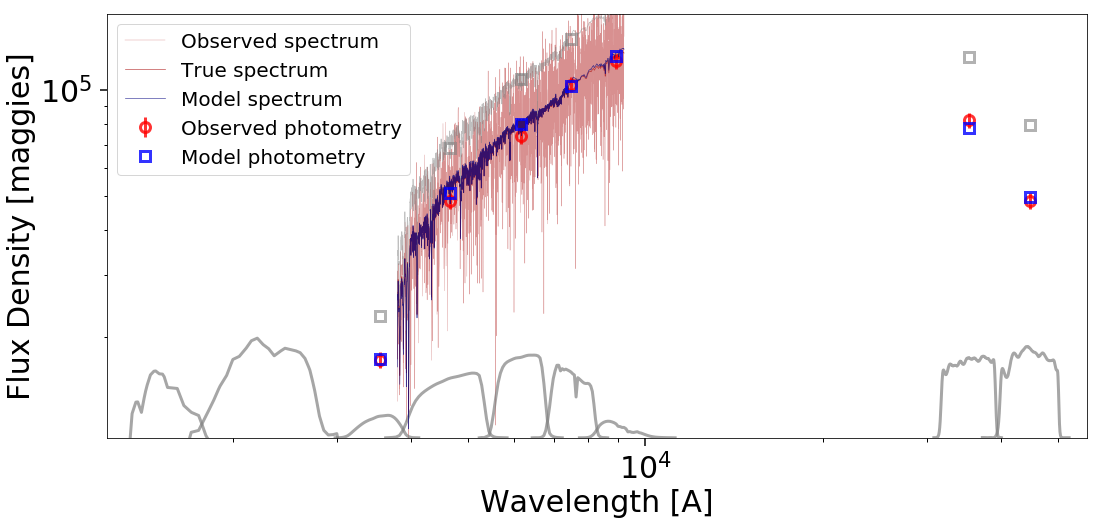

In [15]:
theta = model.rectify_theta(min_results.x) # initial parameters
mspec, mphot, mextra = model.mean_model(theta, obs, sps=sps) # generate model

# establish bounds
xmin, xmax = wphot.min()*0.8, wphot.max()/0.8
temp = interp(linspace(xmin,xmax,10000), wspec, mspec)
ymin, ymax = temp.min()*0.8, temp.max()/0.8

# plotting 
figure(figsize=(16,8))
for i in xrange(len(wphot)):
    f = obs['filters'][i]
    w, t = f.wavelength.copy(), f.transmission.copy()
    while t.max() > 1:
        t /= 10.
    t = 0.1*(ymax-ymin)*t + ymin
    loglog(w, t, lw=3, color='gray', alpha=0.7)
if obs['spectrum'] is not None:
    loglog(wspec, obs['spectrum'], lw=0.4, color='firebrick', alpha=0.5, label='Observed spectrum', zorder=1)
loglog(wspec, obs['true_spectrum'], lw=0.7, color='firebrick', alpha=0.8, label='True spectrum', zorder=1)
errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'], ecolor='red', marker='o', ls='', lw=3, markersize=10, 
         markerfacecolor='none', markeredgecolor='red', markeredgewidth=3, alpha=0.8, 
         label='Observed photometry', zorder=2)
loglog(wspec, mspec_init, lw=0.7, color='gray', alpha=0.5, zorder=3)
errorbar(wphot, mphot_init, marker='s', ls='', lw=3, markersize=10,
         markerfacecolor='none', markeredgecolor='gray', markeredgewidth=3, alpha=0.6, zorder=4)
loglog(wspec, mspec, lw=0.7, color='navy', alpha=0.7, label='Model spectrum', zorder=5)
errorbar(wphot, mphot, marker='s', ls='', lw=3, markersize=10,
         markerfacecolor='none', markeredgecolor='blue', markeredgewidth=3, alpha=0.8, 
         label='Model photometry', zorder=6)
xlabel('Wavelength [A]')
ylabel('Flux Density [maggies]')
xlim([xmin, xmax])
ylim([ymin, ymax])
legend(loc='best', fontsize=20)
tight_layout()

## Sampling: MCMC

Now that we're burned in, we can begin sampling from the posterior using **Markov Chain Monte Carlo** (MCMC). We'll use the **affine-invariant ensemble MCMC sampler** outlined in Goodman & Weare (2010) and popularized by Foreman-Mackey et al. (2013) as **emcee**.

### Basics: MCMC

We evolve an individual chain in an MCMC sampler in three steps:
1. Based on the chain's current position $\mathbf{X}^{(t)}$ at iteration $t$, propose a new position $\mathbf{X}^{(t+1)}$ drawn from a **proposal distribution** (i.e. neighborhood function) $\mathbf{X}^{(t+1)} \sim g(\mathbf{X}^{(t+1)} = \mathbf{x}^{(t+1)} \,|\, \mathbf{X}^{(t)})$.
2. Compute the posterior $P(\mathbf{X}^{(t+1)} \,|\, \mathbf{D})$ given our data $\mathbf{D}$ at the proposed position $\mathbf{X}^{(t+1)}$.
3. Transition to the proposed state (i.e. accept the proposal) according to a **Metropolis update** with **transition probability** $A(\mathbf{X}^{(t+1)} \,|\, \mathbf{X}^{(t)}) = \min \left\lbrace 1, \frac{g(\mathbf{X}^{(t)} \,|\, \mathbf{X}^{(t+1)})}{g(\mathbf{X}^{(t+1)} \,|\, \mathbf{X}^{(t)})} \frac{P(\mathbf{X}^{(t+1)} \,|\, \mathbf{D})}{P(\mathbf{X}^{(t)} \,|\, \mathbf{D})} \right\rbrace$.

Typically, a sampler will run $n$ chains where the proposal distribution for each chain $i$ at iteration $t$ is **additive** and centered on $\mathbf{X}_i^{(t)}$ such that 

$$ 
\mathbf{X}_i^{(t+1)} = \mathbf{X}_i^{(t)} + \mathbf{Z}_i \quad , \quad 
\mathbf{Z}_i \sim g_i(\mathbf{Z}_i = \mathbf{z})
$$ 

where the proposal $g_i(\mathbf{z})$ is symmetric. A common choice is a multivariate Normal such that $g_i(\mathbf{z}) = \mathcal{N}(\mathbf{z} \,|\, \mathbf{0}, \mathbf{C}_i)$. The resulting proposal distribution for $g(\mathbf{X}^{(t+1)} \,|\, \mathbf{X}^{(t)})$ is then symmetric between $\mathbf{X}_i^{(t)}$ and $\mathbf{X}_i^{(t+1)}$, so the transition probability simply reduces to $A(\mathbf{X}_i^{(t+1)} \,|\, \mathbf{X}_i^{(t)}) = \min \left\lbrace 1, \frac{P(\mathbf{X}_i^{(t+1)} \,|\, \mathbf{D})}{P(\mathbf{X}_i^{(t)} \,|\, \mathbf{D})} \right\rbrace$.

### Basics: emcee

The proposal distribution for the affine-invariant ensemble (i.e. particle) sampler differs from that of a typical proposal in three ways:
1. The proposal for a **walker** (emcee's version of a chain) $i$ at $\mathbf{X_i}$ is centered on the position of a randomly selected walker $j \neq i$ located at position $\mathbf{X}_j$.
2. The breadth of the proposal is based on the distance between the two walkers $\Delta \mathbf{X}_{ij} \equiv \mathbf{X}_i - \mathbf{X}_j$.
3. The proposal is **multiplicative** rather than additive.

This allows it to adapt to features in the space in a way that is robust to linear transformations.

More formally, emcee's affine-invariant update is a **stretch move** where the new position $\mathbf{X}_i(t+1)$ is proposed via

$$ \mathbf{X}_i^{(t+1)} = \mathbf{X}_j^{(t)} + Z \, \Delta \mathbf{X}_{ij}^{(t)} $$

where $\Delta \mathbf{X}_{ij} \equiv \mathbf{X}_i - \mathbf{X}_j$ is the vector spanning the two walkers and 

$$ Z \sim g(Z = z) \quad , \quad g(z) \equiv z^{-1/2} \: \textrm{for} \: z \in \left[a^{-1}, a \right] \: \textrm{and zero otherwise} $$

is drawn from our stretch proposal, where $a$ is most often set to 2.

It is important to note that the resulting proposal is *not* symmetric between $\mathbf{X}_i^{(t)}$ and $\mathbf{X}_i^{(t+1)}$ due to the differences in the relative vector span $\Delta \mathbf{X}_{ij}^{(t)}$ and $\Delta \mathbf{X}_{ij}^{(t+1)}$. The modified Metropolis update can, however, be shown to be

$$ A(\mathbf{X}_i^{(t+1)} \,|\, \mathbf{X}_i^{(t)}) = \min \left\lbrace 1, Z^{N-1} \frac{P(\mathbf{X}_i^{(t+1)} \,|\, \mathbf{D})}{P(\mathbf{X}_i^{(t)} \,|\, \mathbf{D})} \right\rbrace \quad . $$

Intuitively, we can understand the prefactor by noting that the particular functional form for $g(z)$ gives an update proportional to $z^{-1/2}$ that shows up in both parts of our proposal, giving us a constant prefactor of $Z^{-1}$. However, since $g(z^{-1}) = z g(z)$ and we've applied our stretch factor $Z$ in $N$ dimensions, we pick up a factor of $Z^{N}$. Functionally, this just means that we reward large stretch moves (which are more unlikely) and penalize small stretch moves (which are more likely).

In [16]:
# affine-invariant proposal
def aff_inv_proposal(z, a=2):
    norm = sqrt(a) / 2 * (a-1)
    if 1./a <= z <= a:
        return norm / sqrt(z)
    else:
        return 0.

# initialize proposal distribution
from scipy.interpolate import interp1d
a = 2. # stretch scale
zgrid = concatenate(([1./a-1e-10], logspace(-1*log10(a), 1*log10(a), 1000), [a+1e-10]), axis=0) # z grid
gzgrid = array([aff_inv_proposal(z) for z in zgrid]) # g(z) PDF
gzcdf = array([trapz(gzgrid[:i+1], zgrid[:i+1]) for i in xrange(len(zgrid-1))]) # g(z) CDF
fzprob = interp1d(gzcdf, zgrid) # g(z) inverse CDF

In [17]:
# select walker for proposal
def pick_walker(idx):
    return (idx + randint(1, Nwalkers)) % Nwalkers

# stretch move
def stretch():
    return fzprob(rand())

# metropolis update
def metro_prob(lnp_prop, lnp_old, Z, Ndim):
    return exp(lnp_prop - lnp_old) * Z**(Ndim-1)

In [18]:
# update a walker
def walker_update(idx, pos, lnp, lnprobfn, Ndim, T=1.):
    idx_new = pick_walker(idx)
    pos_new, pos_old = pos[idx_new], pos[idx]
    Z = stretch()
    pos_prop = pos_new + Z * (pos_old - pos_new)
    lnp_prop, lnp_old = lnprobfn(pos_prop), lnp[idx]
    mprob = metro_prob(lnp_prop, lnp_old, Z, Ndim)
    if T != 1.: mprob = mprob**(1./T)
    if rand() <= mprob:
        return pos_prop, lnp_prop
    else:
        return pos_old, lnp_old

In [19]:
# emcee sampler w/ simulated annealing
def sample(Niter, pos_init, lnp_init, lnprobfn, Nburnin, T_max):
    
    Nwalkers, Ndim = pos_init.shape # initialize dimensions
    pos_burn = empty((Nburnin, Nwalkers, Ndim), dtype='float32') # positions
    lnp_burn = empty((Nburnin, Nwalkers), dtype='float32') # lnP
    pos_burn[0], lnp_burn[0] = pos_init, lnp_init # starting positions
    T_schedule = linspace(T_max, 1, Nburnin-1)
    
    for i in xrange(1, Nburnin):
        if i%10==0: 
            sys.stderr.write(str(i)+' ')
            good_walkers = lnp_burn[i-1] > median(lnp_burn[i-1])
            mu = mean(pos_burn[i-1,good_walkers], axis=0)
            sig = cov(pos_burn[i-1,good_walkers], rowvar=False)
            pos_burn[i-1,~good_walkers] = multivariate_normal(mu, sig, size=Nwalkers/2)
        for j in xrange(Nwalkers):
            pos_burn[i,j], lnp_burn[i,j] = walker_update(j, pos_burn[i-1], lnp_burn[i-1], 
                                                         lnprobfn, Ndim, T=T_schedule[i-1])
    
    pos_chain = empty((Niter, Nwalkers, Ndim), dtype='float32') # positions
    lnp_chain = empty((Niter, Nwalkers), dtype='float32') # lnP
    for j in xrange(Nwalkers):
        pos_chain[0,j], lnp_chain[0,j] = walker_update(j, pos_burn[-1], lnp_burn[-1], lnprobfn, Ndim)
    
    # serially iterate over each walker
    for i in xrange(1, Niter):
        if i%10==0: sys.stderr.write(str(i)+' ')
        for j in xrange(Nwalkers):
            pos_chain[i,j], lnp_chain[i,j] = walker_update(j, pos_chain[i-1], lnp_chain[i-1], lnprobfn, Ndim)
    return pos_chain, lnp_chain, pos_burn, lnp_burn

In [20]:
Nwalkers = 128
Ntheta = len(model.free_params)
pos_init = empty((Nwalkers, Ntheta), dtype='float')
lnp_init = empty(Nwalkers)

for i in xrange(Nwalkers):
    while True:
        pos = normal(min_results.x, scale=diff(model.theta_bounds()).flatten()/10.)
        inbounds = prod([model.theta_bounds()[j][0] <= pos[j] <= model.theta_bounds()[j][1] 
                         for j in xrange(Ntheta)])
        if inbounds:
            sys.stdout.write(str(i)+' ')
            pos_init[i], lnp_init[i] = pos, lnprobfn(pos)
            break

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 

In [25]:
sys.stdout = fnull

Nburn, Niter = 256, 512
T_max = 25.
tstart = time.time()
pos_chain, lnp_chain, pos_burn, lnp_burn = sample(Niter, pos_init, lnp_init, lnprobfn, Nburn, T_max)
edur = time.time() - tstart

sys.stdout = fout

print('done emcee in {0}s'.format(edur))

/home/joshspeagle/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: overflow encountered in exp
10 20 /home/joshspeagle/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: overflow encountered in double_scalars
30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 

done emcee in 624.181647062s


## Visualizing the Results

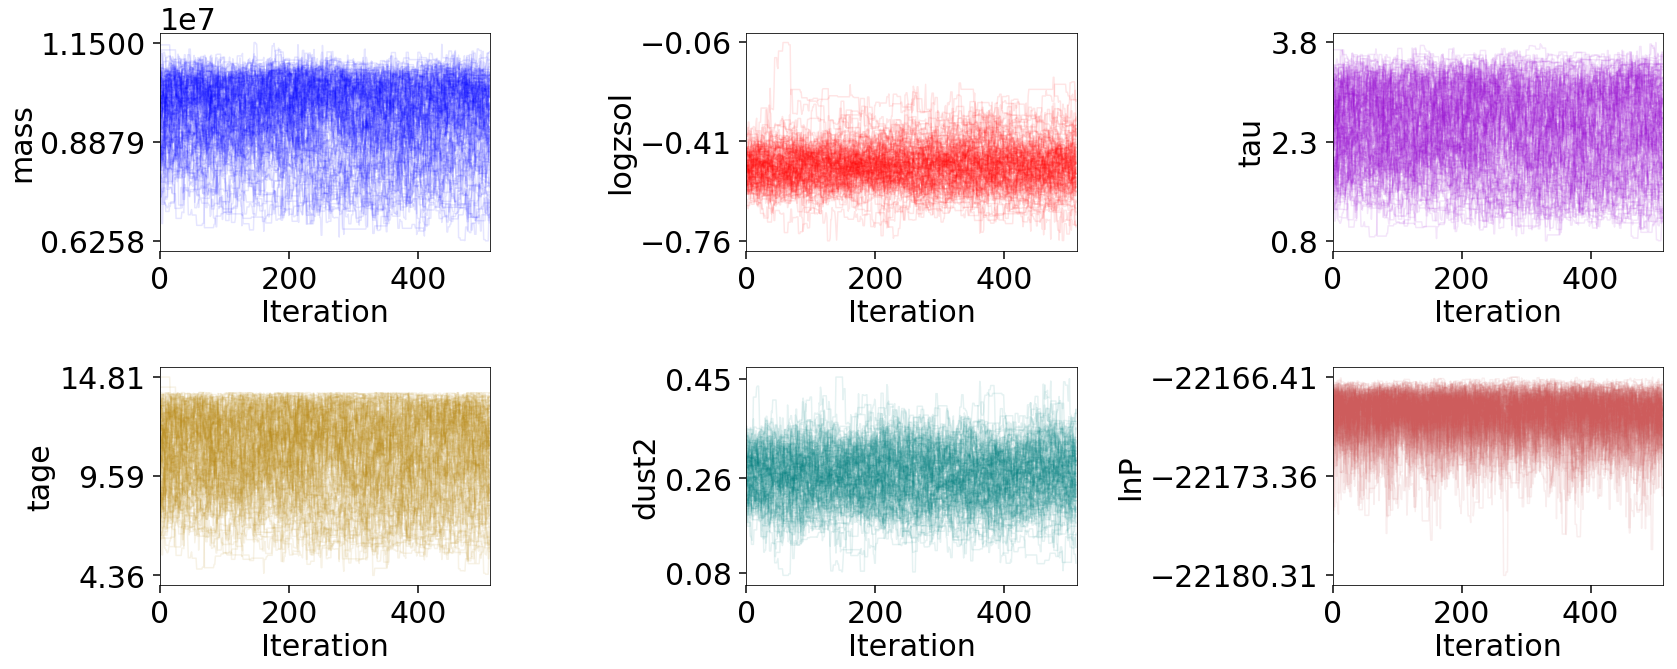

In [26]:
# plot trace
Nburnin, Nthin = 0, 1
varcolors = ['blue', 'red', 'darkviolet', 'darkgoldenrod', 'teal']
varnames = model.free_params
figure(figsize=(24,10))
for i in xrange(Ntheta):
    subplot(2,3,i+1)
    samples = pos_chain[Nburnin::Nthin,:,i]
    plot(arange(Nburnin, Niter, Nthin), samples, lw=1.5, alpha=0.1, color=varcolors[i])
    ymin, ymax = samples.min(), samples.max()
    yticks(linspace(ymin, ymax, 3).round(2))
    xlabel('Iteration')
    xlim([Nburnin, Niter])
    ylabel(varnames[i])
    tight_layout()
subplot(2,3,6)
samples = lnp_chain[Nburnin::Nthin]
plot(arange(Nburnin, Niter, Nthin), samples, lw=1.5, alpha=0.1, color='indianred')
ymin, ymax = samples.min(), samples.max()
yticks(linspace(ymin, ymax, 3).round(2))
xlabel('Iteration')
xlim([Nburnin, Niter])
ylabel('lnP')
tight_layout()

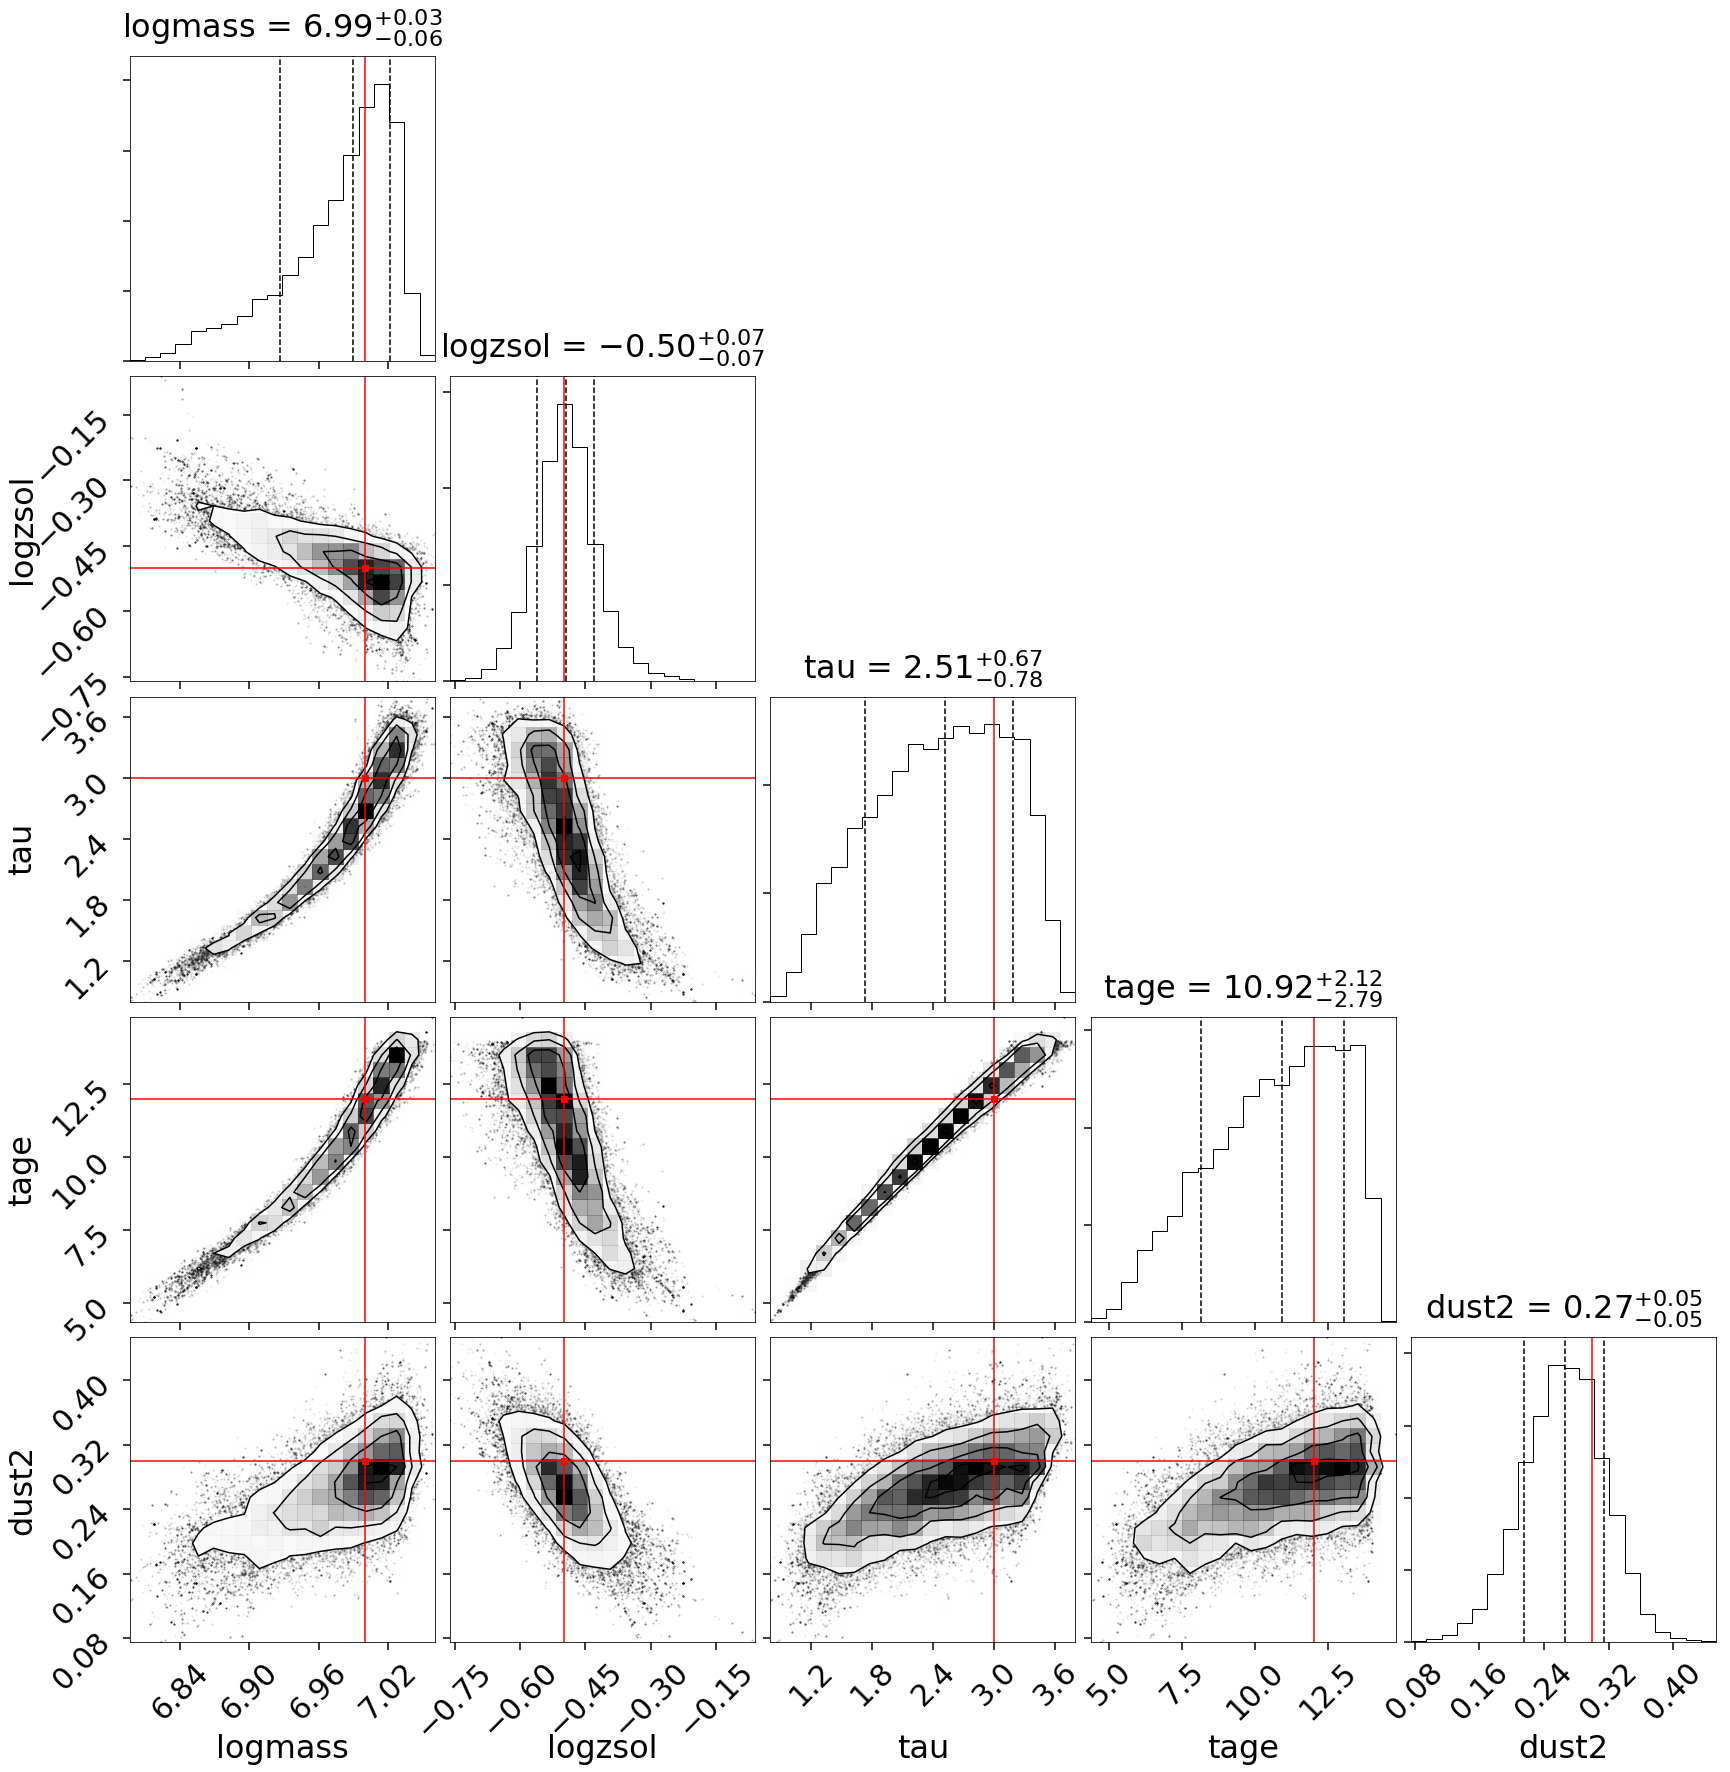

In [40]:
import corner
flatchain = pos_chain[Nburnin::Nthin].T.reshape(5,-1).T
theta_truth = array([run_params[i] for i in ['mass','logzsol','tau','tage','dust2']])
varnames[0], theta_truth[0], flatchain[:,0] = 'logmass', log10(theta_truth[0]), log10(flatchain[:,0])
fig = corner.corner(flatchain, quantiles=[.16, .50, .84],
                    labels=varnames, label_kwargs={'fontsize': 32}, 
                    truths=theta_truth, truth_color='red', 
                    show_titles=True, title_kwargs={'y': 1.04, 'fontsize': 32},
                    fig=subplots(5,5,figsize=(25,25))[0])

Finally, let's just take a look at a random model drawn from our chain.

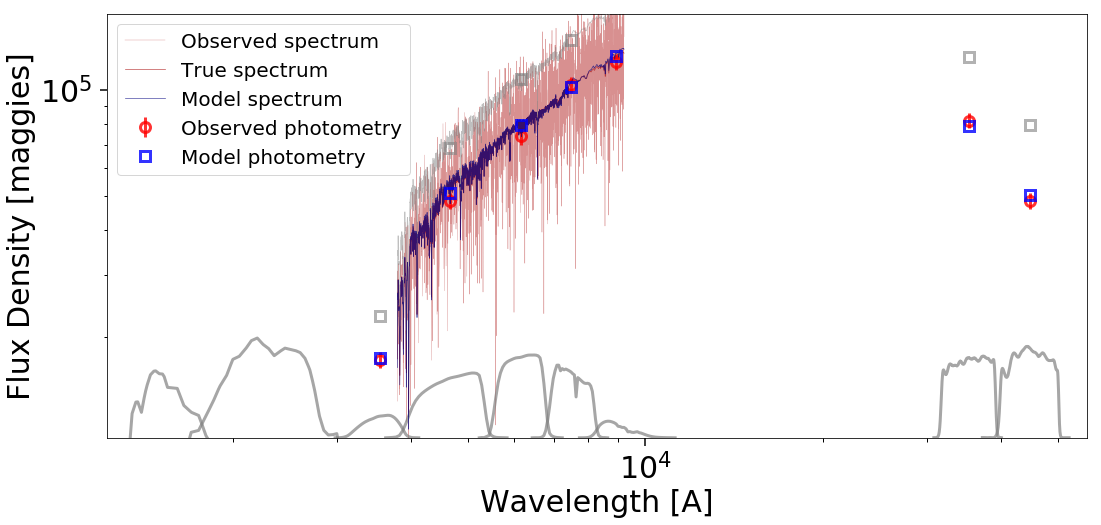

In [29]:
theta = pos_chain[randint(Niter), randint(Nwalkers)] # random parameters
mspec, mphot, mextra = model.mean_model(theta, obs, sps=sps) # generate model

# establish bounds
xmin, xmax = wphot.min()*0.8, wphot.max()/0.8
temp = interp(linspace(xmin,xmax,10000), wspec, mspec)
ymin, ymax = temp.min()*0.8, temp.max()/0.8

# plotting 
figure(figsize=(16,8))
for i in xrange(len(wphot)):
    f = obs['filters'][i]
    w, t = f.wavelength.copy(), f.transmission.copy()
    while t.max() > 1:
        t /= 10.
    t = 0.1*(ymax-ymin)*t + ymin
    loglog(w, t, lw=3, color='gray', alpha=0.7)
if obs['spectrum'] is not None:
    loglog(wspec, obs['spectrum'], lw=0.4, color='firebrick', alpha=0.5, label='Observed spectrum', zorder=1)
loglog(wspec, obs['true_spectrum'], lw=0.7, color='firebrick', alpha=0.8, label='True spectrum', zorder=1)
errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'], ecolor='red', marker='o', ls='', lw=3, markersize=10, 
         markerfacecolor='none', markeredgecolor='red', markeredgewidth=3, alpha=0.8, 
         label='Observed photometry', zorder=2)
loglog(wspec, mspec_init, lw=0.7, color='gray', alpha=0.5, zorder=3)
errorbar(wphot, mphot_init, marker='s', ls='', lw=3, markersize=10,
         markerfacecolor='none', markeredgecolor='gray', markeredgewidth=3, alpha=0.6, zorder=4)
loglog(wspec, mspec, lw=0.7, color='navy', alpha=0.7, label='Model spectrum', zorder=5)
errorbar(wphot, mphot, marker='s', ls='', lw=3, markersize=10,
         markerfacecolor='none', markeredgecolor='blue', markeredgewidth=3, alpha=0.8, 
         label='Model photometry', zorder=6)
xlabel('Wavelength [A]')
ylabel('Flux Density [maggies]')
xlim([xmin, xmax])
ylim([ymin, ymax])
legend(loc='best', fontsize=20)
tight_layout()

In [34]:
import pickle
outroot = "{0}_{1}".format(run_params['outfile'], int(time.time()))
esampler = pos_chain, lnp_chain, pos_burn, lnp_burn
pickle.dump([run_params, model, obs, esampler, min_results], open(outroot, "wb"))